In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import Python Modules

In [13]:
# Main PODPAC library
import podpac
podpac.settings['DEFAULT_CACHE'] = ['ram']
podpac.settings['RAM_CACHE_ENABLED'] = True

# Data source nodes
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory, DroughtCategory

# Algorithm nodes
from podpac.algorithm import YearSubstituteCoordinates, Arithmetic

# Retrieve Data 
## Computed Drought Categories
* We computed these categories from historical SMAP data and staged the results on AWS S3. 
* To access these datasets, our specific AWS credentials are required.

In [9]:
podpac.settings.set_unsafe_eval(True)

In [65]:
# AWS bucket where data lives
bucket = "podpac-internal-test"
# Name of the file, in 'zarr' format
store = "drought_parameters.zarr"
# Path used by PODPAC to retrieve the data
source = 's3://%s/%s' % (bucket, store)

# Create the node that points to the .zarr file on S3
d0_source = DroughtMonitorCategory(datakey='d0', source=source)

# All of our data uses the year '2018', but really describe a climatology. 
# Hence, any incoming requests should have the year replaced by '2018'
year = '2018'

# This algorithm node take the incoming request, replaces the year by 2018, evaluates the d0_source node, 
# then substitutes the original date in the result
d0 = YearSubstituteCoordinates(year=year, source=d0_source, substitute_eval_coords=True)

# Repeat for the other categories
d1 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d1', source=source), year=year, substitute_eval_coords=True)
d2 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d2', source=source), year=year, substitute_eval_coords=True)
d3 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d3', source=source), year=year, substitute_eval_coords=True)
d4 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d4', source=source), year=year, substitute_eval_coords=True)

## Raw SMAP Soil Moisture Data
* We retrieve this data from NSIDC through the EGI (Earthdata Gateway Interface). 
* We retrieve level 3 data that have AM and PM returns, and we composite them together.

In [11]:
source = 's3://%s/%s' % (bucket, 'SPL3SMP_E.002_9km_aid0001.zarr')
source2 = 's3://%s/%s' % (bucket, 'SPL4SMGP.004_9km_aid0001.zarr')

kwargs = {'dims': ['time', 'lat', 'lon'], 'latkey': 'fakedim0', 'lonkey': 'fakedim1',
          'cf_time': True, 'cf_calendar': 'proleptic_gregorian', 'cf_units': 'days since 2000-01-01',
         'crs': 'epsg:6933', 'nan_vals': [-9999]}
smap_e_am_raw = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_soil_moisture', **kwargs)
smap_e_pm_raw = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm', **kwargs)
smap_e_am_qf = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag', **kwargs)
smap_e_pm_qf = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm', **kwargs)

smap_e_am = podpac.algorithm.Mask(source=smap_e_am_raw, mask=smap_e_am_qf,
                                       bool_val=1, bool_op='>')
smap_e_pm = podpac.algorithm.Mask(source=smap_e_pm_raw, mask=smap_e_pm_qf,
                                       bool_val=1, bool_op='>')


smap_L4 = podpac.data.Zarr(source=source2, datakey='Geophysical_Data_sm_surface', **kwargs)

smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
                                                    smap_e_pm,
                                                    smap_L4
                                                   ], source='SMAP L3 AM/PM Combined')

In [66]:
source = 's3://%s/%s' % (bucket, 'SPL3SMP_E.002_9km_aid0001.zarr')
source2 = 's3://%s/%s' % (bucket, 'SPL4SMGP.004_9km_aid0001.zarr')

kwargs = {'dims': ['time', 'lat', 'lon'], 'latkey': 'fakedim0', 'lonkey': 'fakedim1',
          'cf_time': True, 'cf_calendar': 'proleptic_gregorian', 'cf_units': 'days since 2000-01-01',
         'crs': 'epsg:6933', 'nan_vals': [-9999]}
smap_e_am_raw = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_soil_moisture', **kwargs)
smap_e_am_qf = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag', **kwargs)

smap_e_am = podpac.algorithm.Mask(source=smap_e_am_raw, mask=smap_e_am_qf,
                                  bool_val=1, bool_op=">")
smap_e_window = podpac.algorithm.ExpandCoordinates(source=smap_e_am, 
                                                   time=['-5,D', '0,D', '1,D']
                                                 )
smap_L3 = podpac.algorithm.Mean(source=smap_e_window, dims='time')
smap_L4 = podpac.algorithm.Mean(source=podpac.data.Zarr(source=source2, datakey='Geophysical_Data_sm_surface', **kwargs),
                                dims='time')

smap = podpac.compositor.OrderedCompositor(sources=[smap_L3,
                                                    smap_L4
                                                   ], source='SMAP L3 AM/PM Combined')

C:\Users\mpu\Downloads\PODPAC_latest_install_windows10\podpac-1.2.0\podpac\podpac\core\coordinates\dependent_coordinates.py:496: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")
C:\Users\mpu\Downloads\PODPAC_latest_install_windows10\podpac-1.2.0\podpac\podpac\core\coordinates\dependent_coordinates.py:498: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")
C:\Users\mpu\Downloads\PODPAC_latest_install_windows10\podpac-1.2.0\miniconda\envs\podpac\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


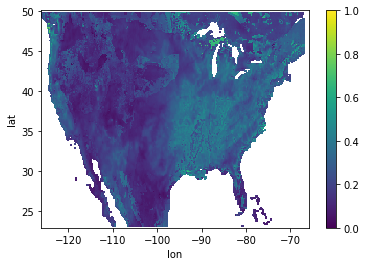

In [61]:
# Check The Coordinates
coords2 = podpac.Coordinates([podpac.clinspace(50, 23, 256), podpac.clinspace(-126, -66, 256), '2019-12-02'],
                            ['lat', 'lon', 'time'])
o = smap.eval(coords2)
o.plot(vmin=0, vmax=1)

In [ ]:
# Get combined smap data
# smap_e_am = SMAP(product='SPL3SMP_E_AM', page_size=40)
# smap_e_pm = SMAP(product='SPL3SMP_E_PM', page_size=40)
# smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
#                                                     smap_e_pm,
#                                                    ], source='SMAP L3 AM/PM Combined')

# Create algorithm to convert raw SMAP data to drought categories
* We use an Arithmetic node computes pixel-wise results using an arbitrary equation
* The inputs come from the previously-created nodes, with an A, B, C,... naming convention

In [69]:
# Create the drought Categorization algorithm
alg = DroughtCategory(d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, soil_moisture=smap)
alg_e_am = DroughtCategory(d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, soil_moisture=smap_e_am)

# Test the PODPAC Algorithm Locally
## Create Coordinates
* The nodes will be evaluated at these coordinates. 
* **Note**: the time series of the categories and the SMAP data do not line up, but PODPAC deals with the automatically using nearest-neighbor interpolation (by default). 

In [ ]:
coords = podpac.Coordinates([43, -72,
                             podpac.crange('2019-04-12', '2019-07-10', '3,D')],
                            ['lat', 'lon', 'time'])

## Evaluate the Node Locally

In [ ]:
# Most of the execution time comes from retrieving SMAP data via EGI
# The results of this request is cached, so subsequent eval's are fast
o = alg.eval(coords)

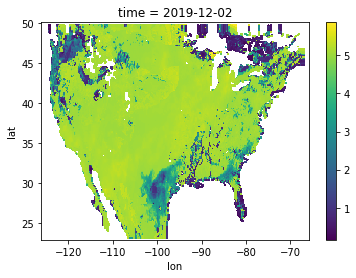

In [63]:
o = alg.eval(coords2)
o.plot()

In [ ]:
podpac.utils.clear_cache(mode='ram')

In [ ]:
%%timeit
with podpac.settings:
    podpac.settings['DEFAULT_CACHE'] = []
    podpac.settings['RAM_CACHE_ENABLED'] = False
    podpac.settings["CACHE_OUTPUT_DEFAUL"] = False
    podpac.settings['MULTITHREADING'] = True
    podpac.settings['N_THREADS'] = 32
    alg.eval(coords)

In [ ]:
%%timeit
with podpac.settings:
    podpac.settings['DEFAULT_CACHE'] = []
    podpac.settings['RAM_CACHE_ENABLED'] = False
    podpac.settings["CACHE_OUTPUT_DEFAUL"] = False
    podpac.settings['MULTITHREADING'] = False
    alg.eval(coords)

## Examine the results

In [ ]:
o.plot()

In [ ]:
o

## Evaluate the Node on the Cloud

In [ ]:
podpac.settings['S3_JSON_FOLDER'] = 'esip_input2/'
podpac.settings['S3_OUTPUT_FOLDER'] = 'esip_output2/'
podpac.settings['S3_BUCKET_NAME'] = 'podpac-s3'

In [ ]:
aws_node = podpac.managers.Lambda(source=alg)
o2 = aws_node.eval(coords)

In [ ]:
o2.plot()

# Export PODPAC Pipelines for development of website
* **Note**, PODPAC kept track of all the nodes used to create the analysis, and recorded this in a light-weight JSON format

In [71]:
def save_json(node, filename):
    with open(filename, 'w') as fid:
        fid.write(node.json_pretty)

# Customize the SMAP node's plot style for WMS Feeds
smap.style.clim = [0, 0.5]
smap.style.colormap = 'gist_earth_r'        
        
save_json(d0, 'pipeline_d0.json')
save_json(d1, 'pipeline_d1.json')
save_json(d2, 'pipeline_d2.json')
save_json(d3, 'pipeline_d3.json')
save_json(d4, 'pipeline_d4.json')
save_json(alg, 'pipeline_category.json')
save_json(alg_e_am, 'pipeline_category_l3am.json')
save_json(smap, 'pipeline_moisture.json')
save_json(smap_e_am, 'pipeline_moisture_l3am.json')

print (alg.json_pretty)

{
    "DroughtMonitorCategory": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {
            "altkey": "alt",
            "crs": null,
            "datakey": "d0",
            "file_mode": "r",
            "latkey": "lat",
            "lonkey": "lon",
            "nan_vals": [],
            "timekey": "time"
        },
        "style": {
            "colormap": "gist_earth_r",
            "clim": [
                0,
                0.6
            ]
        },
        "source": "s3://podpac-internal-test/drought_parameters.zarr",
        "interpolation": "nearest"
    },
    "YearSubstituteCoordinates": {
        "node": "core.algorithm.coord_select.YearSubstituteCoordinates",
        "attrs": {
            "substitute_eval_coords": true,
            "year": "2018"
        },
        "inputs": {
            "source": "DroughtMonitorCategory"
        }
    },
    "DroughtMonitorCategory_1": {
        "node": "datalib.drought_monitor.DroughtMonitorC